In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p import dis2pvi_cE as dvi
# from dis2p_reproducibility.dis2p_defunct import dis2pvi_cE as dvi
import biolord
from scvi.model.base import BaseModelClass
from scDisInFact import scdisinfact, create_scdisinfact_dataset

# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


In [3]:
adata = sc.read_h5ad('../kang_normalized_hvg.h5ad')
adata_biolord = sc.read_h5ad('../kang_normalized_hvg.h5ad')

In [4]:
adata = adata[adata.layers['counts'].sum(1) != 0].copy()
adata_biolord = adata_biolord[adata_biolord.layers['counts'].sum(1) != 0].copy()

In [5]:
adata.layers['counts'].max()

3828.0

In [6]:
adata.X.max()

3828.0

In [7]:
adata.X.min()

0.0

In [8]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [56]:
cats = ['cell_type', 'condition']
pre_path = '../models/'
dis2p_model_path = 'kang_dis2p_cE_split_CD4 T/' + '350_split_split_CD4 T_reconW_19.29_cfWeight_0.832_beta_0.003_clf_1.6887_adv_0.0119_advp_5_n_cf_1_lr_0.001_wd_5.69e-05_new_cf_True_dropout_0.2_n_hidden_128_n_latent_32_n_layers_2/'

biolord_model_path = 'biolord/kang_biolord_basicSettings_nb_split_CD4 T/'
scdisinfact_model_path = 'scDisInfact/kang_model_40latent_300ep_split_CD4 T_[8, 2, 2]_[0.0001, 0.0001, 1e-05, 0.01, 1, 1]_64_300_0.0005.pth'

## Load Dis2P

In [57]:
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{dis2p_model_path}", adata=adata)

INFO     File ../models//kang_dis2p_cE_split_CD4 T/350_split_split_CD4                                             
         T_reconW_19.29_cfWeight_0.832_beta_0.003_clf_1.6887_adv_0.0119_advp_5_n_cf_1_lr_0.001_wd_5.69e-05_new_cf_T
         rue_dropout_0.2_n_hidden_128_n_latent_32_n_layers_2/model.pt already downloaded                           


In [58]:
import gc
gc.collect()

42118

## Load Biolord

In [59]:
biolord_model = biolord.Biolord.load(f"{pre_path}/{biolord_model_path}", adata=adata_biolord)

INFO     File ../models//biolord/kang_biolord_basicSettings_nb_split_CD4 T/model.pt already downloaded             


Global seed set to 42


## Load scDisInfact

In [60]:
from scDisInFact import scdisinfact, create_scdisinfact_dataset
import pandas as pd

# declare latent dimensions, we have two condition types, so there are three element corresponding to 
# shared-bio factor, unshared-bio factor for condition 1, unshared-bio factor for condition 2
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 2, 2]
batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4

lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
batch_size = 64
adata_ = adata[adata.layers['counts'].sum(1) != 0].copy()
counts = adata_.layers['counts'].copy()
meta_cells = adata_.obs.copy()
meta_cells['one'] = pd.Categorical([1 for _ in range(adata_.n_obs)])

condition_key = ['cell_type', 'condition']

data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = condition_key, batch_key = "one")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scdisinfact_model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
scdisinfact_model.load_state_dict(torch.load(f"{pre_path}/{scdisinfact_model_path}", map_location = device))

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


<All keys matched successfully>

## Inference scripts

In [61]:
def pred_our_ood_avg(model,
                adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,
                cats: list[str],
                n_samples_from_source = None,
                n_samples: int = 1000,):
    adata.X = adata.layers['counts'].copy()
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata)), n_samples_from_source)
        source_adata = source_adata[chosen_ids].copy()
    adata_cf = source_adata.copy()
        
    
    for i, cov_name in enumerate(cov_names):
        adata_cf.obs.loc[:, cov_name] = pd.Categorical(
            [cov_values_cf[i] for _ in adata_cf.obs[cov_name]])
    batch_size = len(adata_cf)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.setup_anndata(
        adata_cf,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    adata_cf = model._validate_anndata(adata_cf)
    source_adata = model._validate_anndata(source_adata)
    # print("Data loader OOD")
    scdl_cf = model._make_data_loader(
        adata=adata_cf, batch_size=batch_size
    )
    scdl = model._make_data_loader(
        adata=source_adata, batch_size=batch_size
    )
    # cov_idx = cats.index(cov_name)
    px_cf_mean_list = []
    for tensors, tensors_cf in zip(scdl, scdl_cf):
        x, pxs_cf = model.module.sub_forward_cf_avg(
                            x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                            cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device),
                            cat_covs_cf=tensors_cf[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

        # for px_cf in pxs_cf:
        #     samples = []
        #     if px_cf is None:
        #         continue
        #     for _ in range(n_samples):
        #         samples.append(px_cf.sample().to('cpu'))
        #     samples = torch.stack(samples, dim=0)
        #     x_cf = torch.mean(samples, dim=0)
        #     print(samples.shape)
        #     print(x_cf.shape)
        #     px_cf_mean_list.append(x_cf)
        for px_cf in pxs_cf:
            if px_cf is None:
                continue
            x_cf = px_cf.mu
            px_cf_mean_list.append(x_cf)

    px_cf_mean_tensor = torch.stack(px_cf_mean_list, dim=0)
    px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)

    px_cf_mean_pred = px_cf_mean_pred.to('cpu').detach().numpy()
    px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').detach().numpy()

    px_cf_mean_tensor = ad.AnnData(px_cf_mean_pred)
    px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)

    true_x_count = torch.tensor(true_adata.X)
    cf_x_count = torch.tensor(source_adata.X)

    x_true = true_x_count
    x_pred = px_cf_mean_tensor
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true, x_pred, px_cf_mean_tensor, true_x_count

In [62]:
def get_biolord_pred(biolord_model,
                     adata,
                     cell_type_to_check,
                     cov_names,
                     cov_values,
                     cov_values_cf,
                     n_samples_from_source = None,
                    ):
    adata.obs['idx'] = list([i for i in range(len(adata))])
    adata_ = adata[(adata.obs['cell_type'] == cell_type_to_check)].copy()

    source_indices = pd.DataFrame([adata_.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_sub_idx = list(adata_[source_indices].obs['idx'])

    source_adata_biolord = adata_[adata_.obs['idx'].isin(source_sub_idx)]
    
    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata_biolord)), n_samples_from_source)
        source_adata_biolord = source_adata_biolord[chosen_ids].copy()
    biolord_preds = biolord_model.compute_prediction_adata(adata, adata_source=source_adata_biolord, target_attributes=cov_names)
    
    pred_idx = pd.DataFrame([biolord_preds.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    biolord_preds = biolord_preds[pred_idx]

    x_biolord = torch.tensor(biolord_preds.X)
    x_biolord = np.log1p(x_biolord)
                     
    return x_biolord, biolord_preds

In [63]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
def get_scdisinfact_pred(scdisinfact_model,
                         meta_cells,
                         condition_key,
                         counts,
                         cell_type_to_check,
                         cov_names,
                         cov_values,
                         cov_values_cf,
                         n_samples_from_source = None,
                        ):
    meta_cells_ = meta_cells[(meta_cells['cell_type'] == cell_type_to_check) ]
    counts_ = counts[(meta_cells['cell_type'] == cell_type_to_check)]
    
    meta_cells_ = meta_cells_[condition_key + ['one']]
    input_idx = pd.DataFrame([meta_cells_[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    counts_input = counts_[input_idx,:]
    meta_input = meta_cells_.loc[input_idx,:]
    
    for cov in condition_key + ['one']:
        meta_input[cov] = meta_input[cov].astype(str)

    meta_output = meta_input.copy()
    for i, cov in enumerate(cov_names):
        meta_output[cov] = cov_values_cf[i]
   
    counts_predict = []
    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(meta_input)), n_samples_from_source)
    else:
        chosen_ids = range(len(meta_input))
    for i in tqdm(chosen_ids):
        predict_conds = [meta_output[cov][i] for cov in condition_key]
        cell_i = scdisinfact_model.predict_counts(input_counts = counts_input[i, :][None, :],
                                                  meta_cells = meta_input.iloc[[i], :], 
                                                  condition_keys = condition_key, 
                                                  batch_key = "one", 
                                                  predict_conds = predict_conds,)
        counts_predict.append(cell_i)

    counts_predict = np.concatenate(counts_predict)
    x_scdisinfact = torch.tensor(counts_predict)
    x_scdisinfact = np.log1p(x_scdisinfact)
    
    return x_scdisinfact

In [64]:
model

Dis2pVI_cE Model with the following params: 
n_hidden: 128, n_latent_shared: 32, n_latent_attribute: 32, n_layers: 2, dropout_rate: 0.2, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

## Get counterfactual predictions

In [65]:
cell_type_to_check = ['CD4 T',]
# cell_type_to_check = ['B',]

cov_names = ['condition']
cov_values = ['ctrl']
cov_values_cf = ['stimulated']
n_samples_from_source = None

In [66]:
x_ctrl, x_true, x_pred, px_cf_mean_tensor, true_x_count = pred_our_ood_avg(model,
                                          adata[(adata.obs['cell_type'] == cell_type_to_check[0])].copy(),
                                          cov_names=cov_names,
                                          cov_values=cov_values,
                                          cov_values_cf=cov_values_cf,
                                          cats=cats,
                                          n_samples_from_source=n_samples_from_source,
                                         )

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [67]:
x_biolord, biolord_preds = get_biolord_pred(biolord_model,
                                            adata_biolord,
                                            cell_type_to_check[0],
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            n_samples_from_source=n_samples_from_source,
                                           )

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  6.01it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  6.02it/s]


In [68]:
x_scdisinfact = get_scdisinfact_pred(scdisinfact_model,
                                     meta_cells,
                                     condition_key,
                                     counts,
                                     cell_type_to_check[0],
                                     cov_names,
                                     cov_values,
                                     cov_values_cf,
                                     n_samples_from_source=50,
                                    )

100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


In [69]:
print([x.max() for x in [x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]])

[tensor(6.0544), tensor(6.0568), tensor(4.9666), tensor(2.8980), tensor(2.4705)]


In [23]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups_pval0.05"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


In [24]:
adata.uns[key_added].keys()

dict_keys(['CD14 Mono_stimulated', 'CD4 T_stimulated', 'T_stimulated', 'CD8 T_stimulated', 'B_stimulated', 'DC_stimulated', 'CD16 Mono_stimulated', 'NK_stimulated'])

In [25]:
key_added

'rank_genes_groups_pval0.05'

In [70]:
len(adata.uns[key_added]['CD4 T_stimulated'])

160

## DEGs

In [71]:
deg_list = adata.uns[key_added]['CD4 T_stimulated']
r2_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 160, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_biolord_deg = x_biolord[:, degs]
    x_scdisinfact_deg = x_scdisinfact[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_biolord_deg = pearsonr(x_true_deg.mean(0), x_biolord_deg.mean(0))
    r2_mean_scdisinfact_deg = pearsonr(x_true_deg.mean(0), x_scdisinfact_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))
    r2_var_biolord_deg = pearsonr(x_true_deg.var(0), x_biolord_deg.var(0))
    r2_var_scdisinfact_deg = pearsonr(x_true_deg.var(0), x_scdisinfact_deg.var(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Prediction'] = r2_mean_deg[0]
    r2_results[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg[0]
    r2_results[str(n_top_deg)]['scdisinfact'] = r2_mean_scdisinfact_deg[0]
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg[0]

    r2_results[str(n_top_deg)]['Prediction_var'] = r2_var_deg[0]
    r2_results[str(n_top_deg)]['Biolord_var'] = r2_var_biolord_deg[0]
    r2_results[str(n_top_deg)]['scdisinfact_var'] = r2_var_scdisinfact_deg[0]
    r2_results[str(n_top_deg)]['Control_var'] = r2_var_base_deg[0]
    
r2_results = pd.DataFrame.from_dict(r2_results).T

#######################################################################
r2_results_subtract = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 160, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_biolord_deg = x_biolord[:, degs]
    x_scdisinfact_deg = x_scdisinfact[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
    r2_mean_biolord_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_biolord_deg.mean(0) - x_ctrl_deg.mean(0))
    r2_mean_scdisinfact_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_scdisinfact_deg.mean(0) - x_ctrl_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
    r2_var_biolord_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_biolord_deg.var(0) - x_ctrl_deg.var(0))
    r2_var_scdisinfact_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_scdisinfact_deg.var(0) - x_ctrl_deg.var(0))
    
    r2_results_subtract[str(n_top_deg)] = {}
    r2_results_subtract[str(n_top_deg)]['Prediction'] = r2_mean_deg[0]
    r2_results_subtract[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg[0]
    r2_results_subtract[str(n_top_deg)]['scdisinfact'] = r2_mean_scdisinfact_deg[0]

    r2_results_subtract[str(n_top_deg)]['Prediction_var'] = r2_var_deg[0]
    r2_results_subtract[str(n_top_deg)]['Biolord_var'] = r2_var_biolord_deg[0]
    r2_results_subtract[str(n_top_deg)]['scdisinfact_var'] = r2_var_scdisinfact_deg[0]
    
r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T

In [72]:
r2_results_subtract

Prediction   Biolord  scdisinfact  Prediction_var  Biolord_var  \
10     0.933071  0.940640     0.806205       -0.068716     0.774879   
20     0.950637  0.870374     0.901279       -0.212222     0.190943   
40     0.952392  0.854664     0.895618        0.010551     0.225284   
50     0.953689  0.861692     0.898465        0.002299     0.218745   
100    0.766842  0.718259     0.820061        0.168320     0.194660   
150    0.742984  0.728565     0.784882        0.287089     0.306222   
160    0.739073  0.730970     0.772251        0.299623     0.316178   
all    0.618373  0.664892     0.637816       -0.031341     0.013800   

     scdisinfact_var  
10         -0.314988  
20         -0.302711  
40         -0.045740  
50         -0.054432  
100         0.140574  
150         0.263155  
160         0.277728  
all        -0.042427

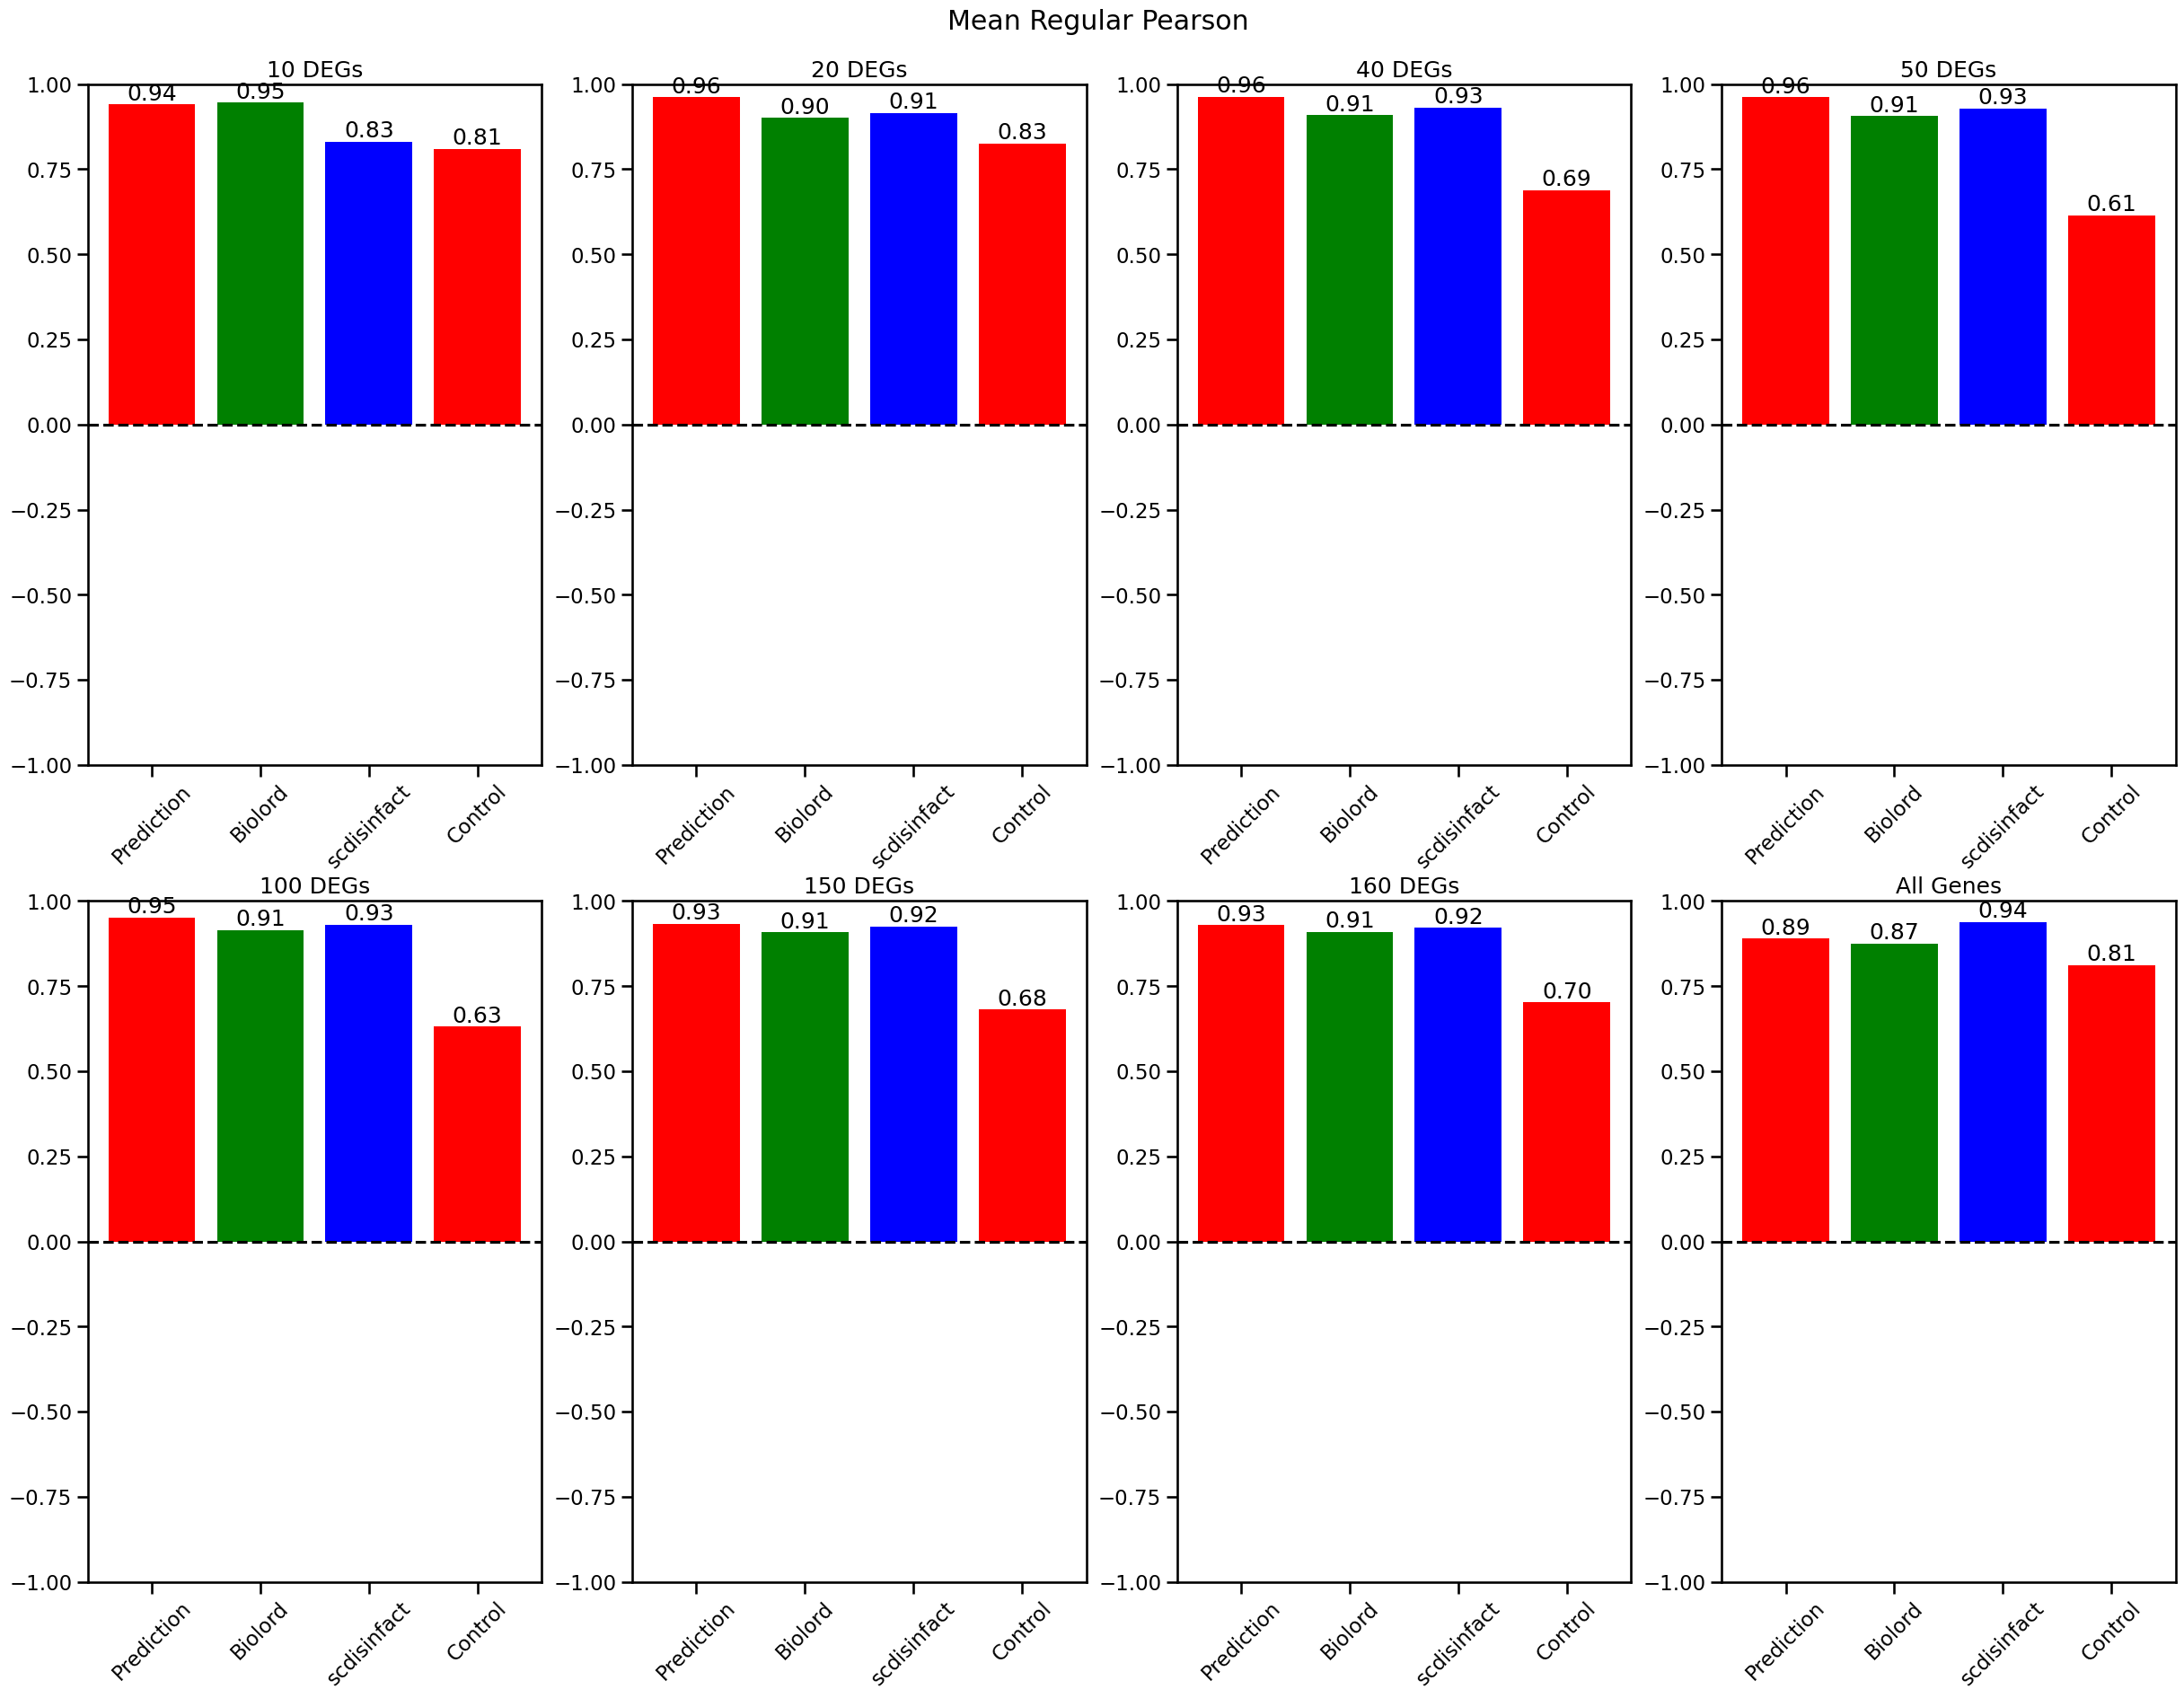

In [74]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][:4]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[:4], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Mean Regular Pearson', y = 1.57)
# plt.title("Mu Regular Pearson")
plt.subplots_adjust(top=1.5)
plt.show()  # Displaying the plot

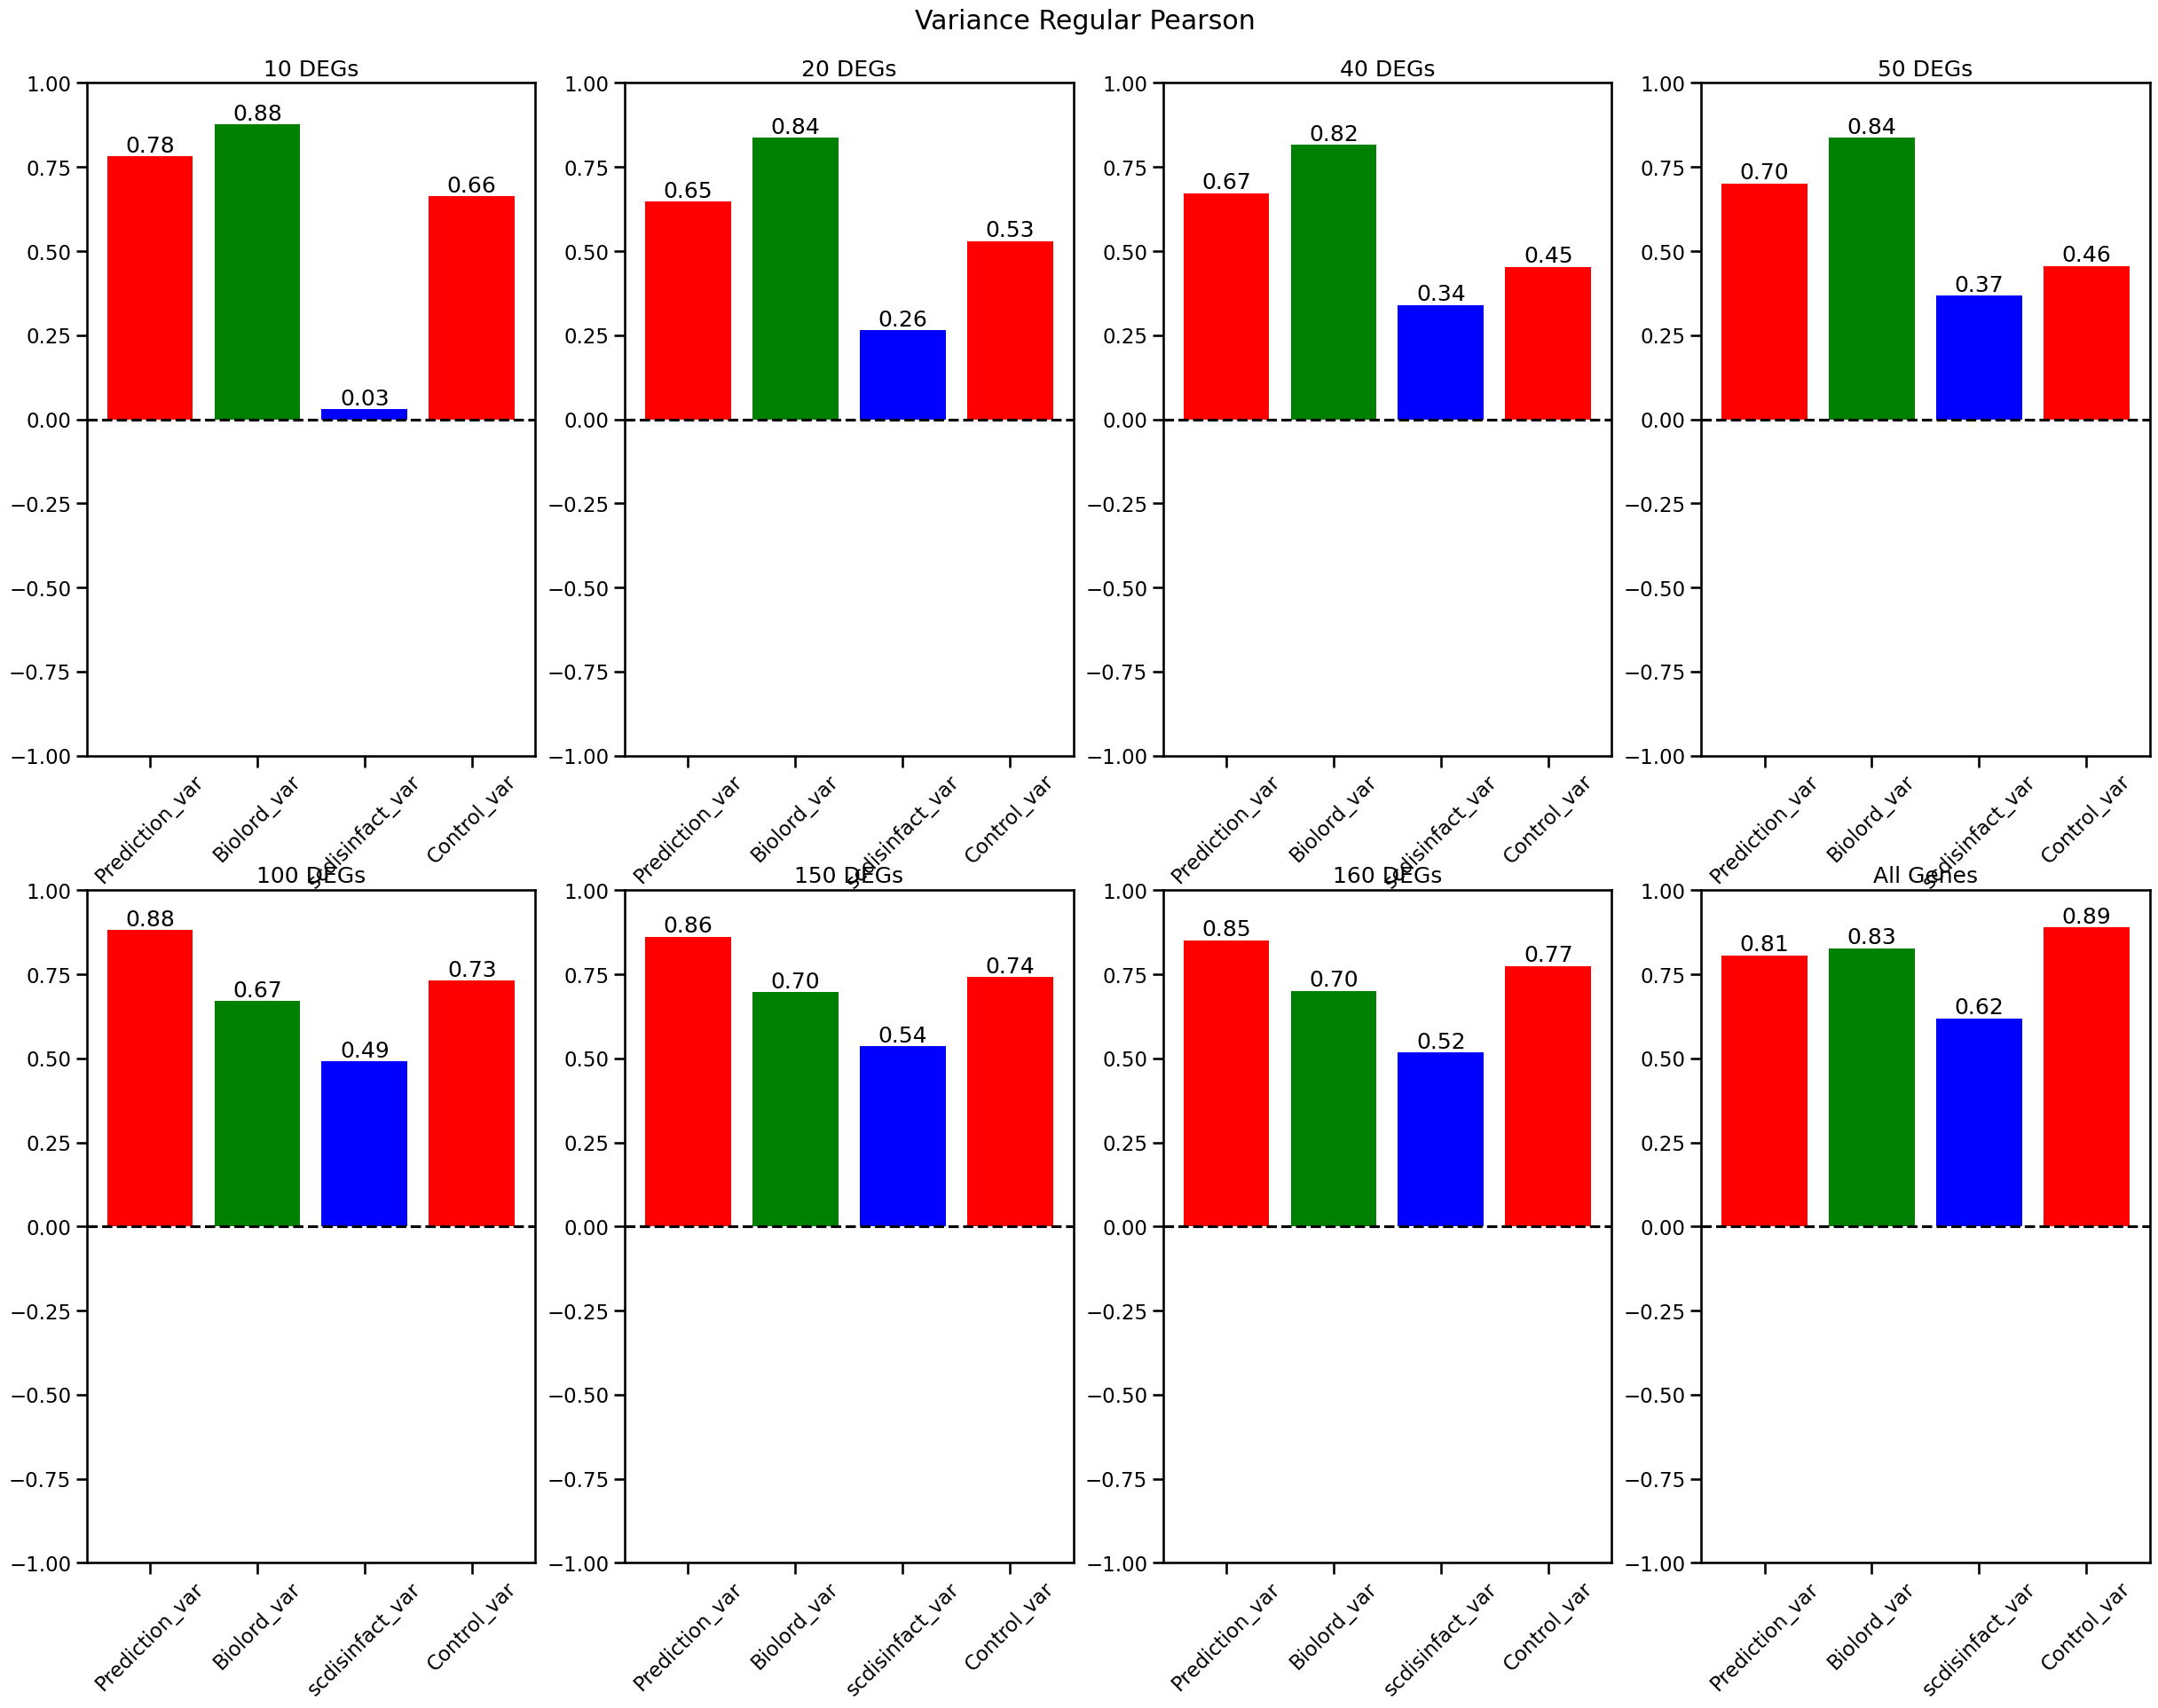

In [76]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][4:]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[4:], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Variance Regular Pearson', y = 1.57)
# plt.title("Mu Regular Pearson")
plt.subplots_adjust(top=1.5)
plt.show()  # Displaying the plot

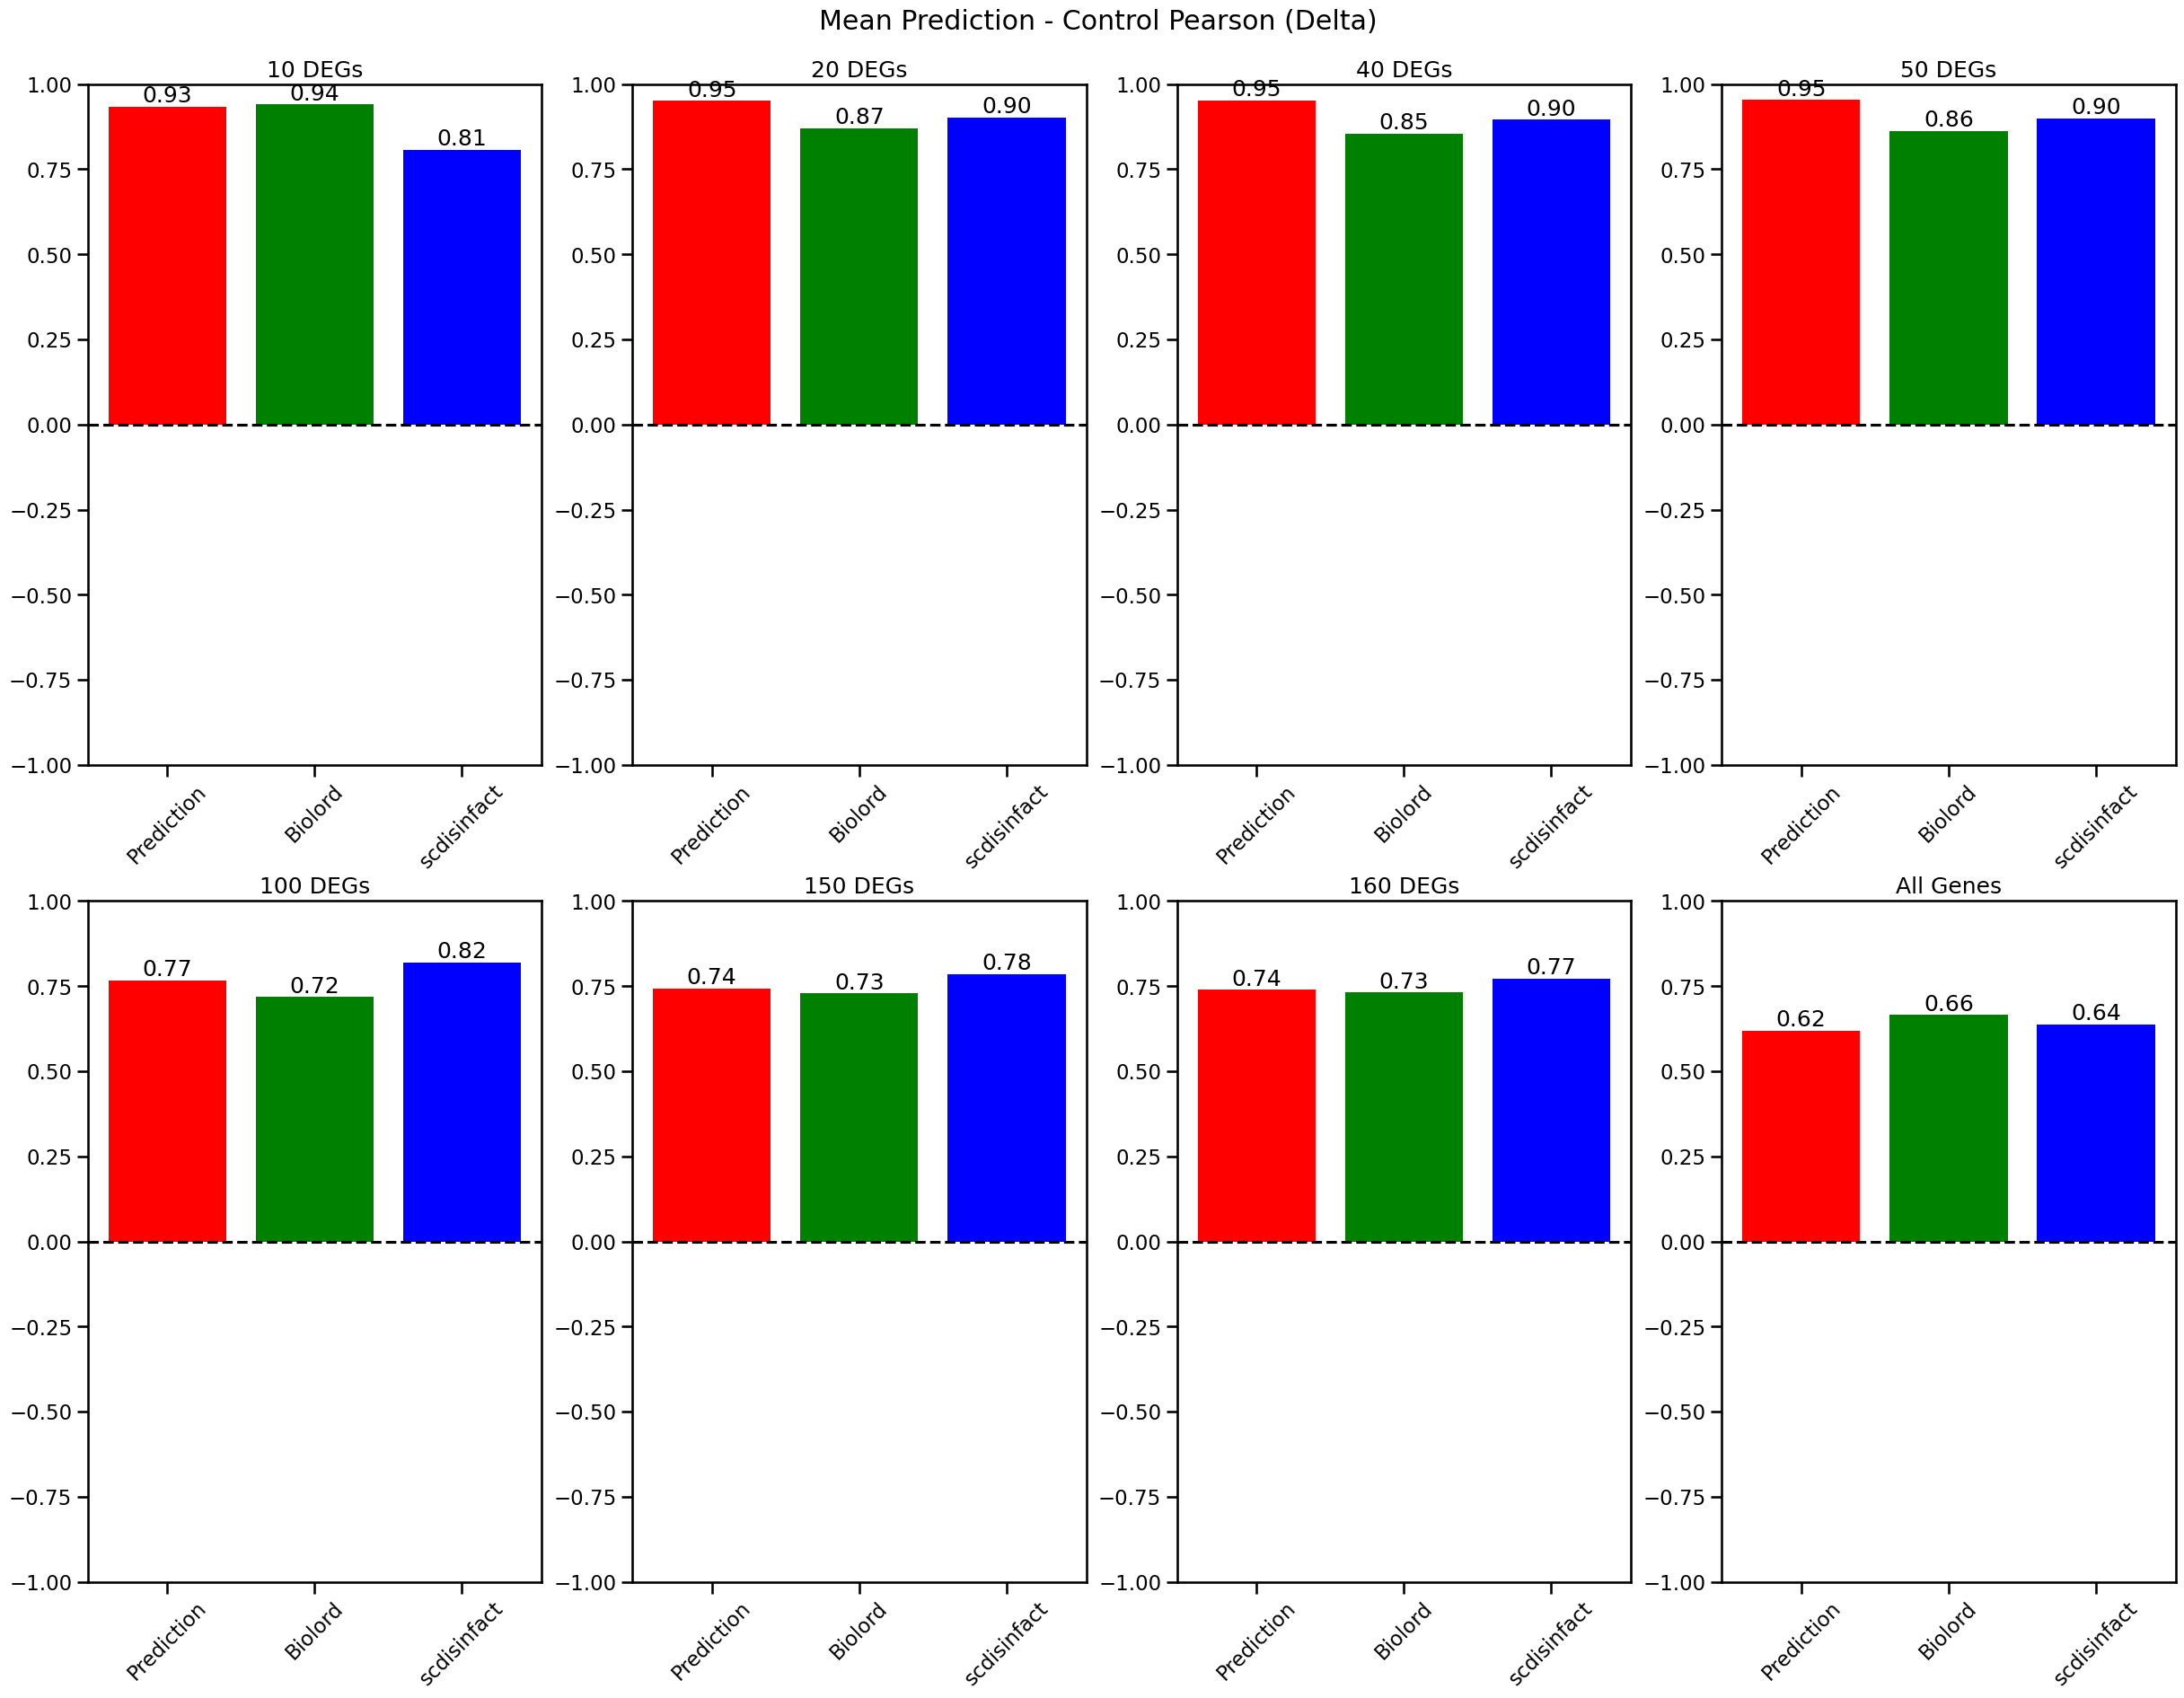

In [77]:
n_rows = r2_results_subtract.shape[0]
df = r2_results_subtract
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][:3]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[:3], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Mean Prediction - Control Pearson (Delta)', y = 1.57)
plt.subplots_adjust(top=1.5)

plt.show()  # Displaying the plot

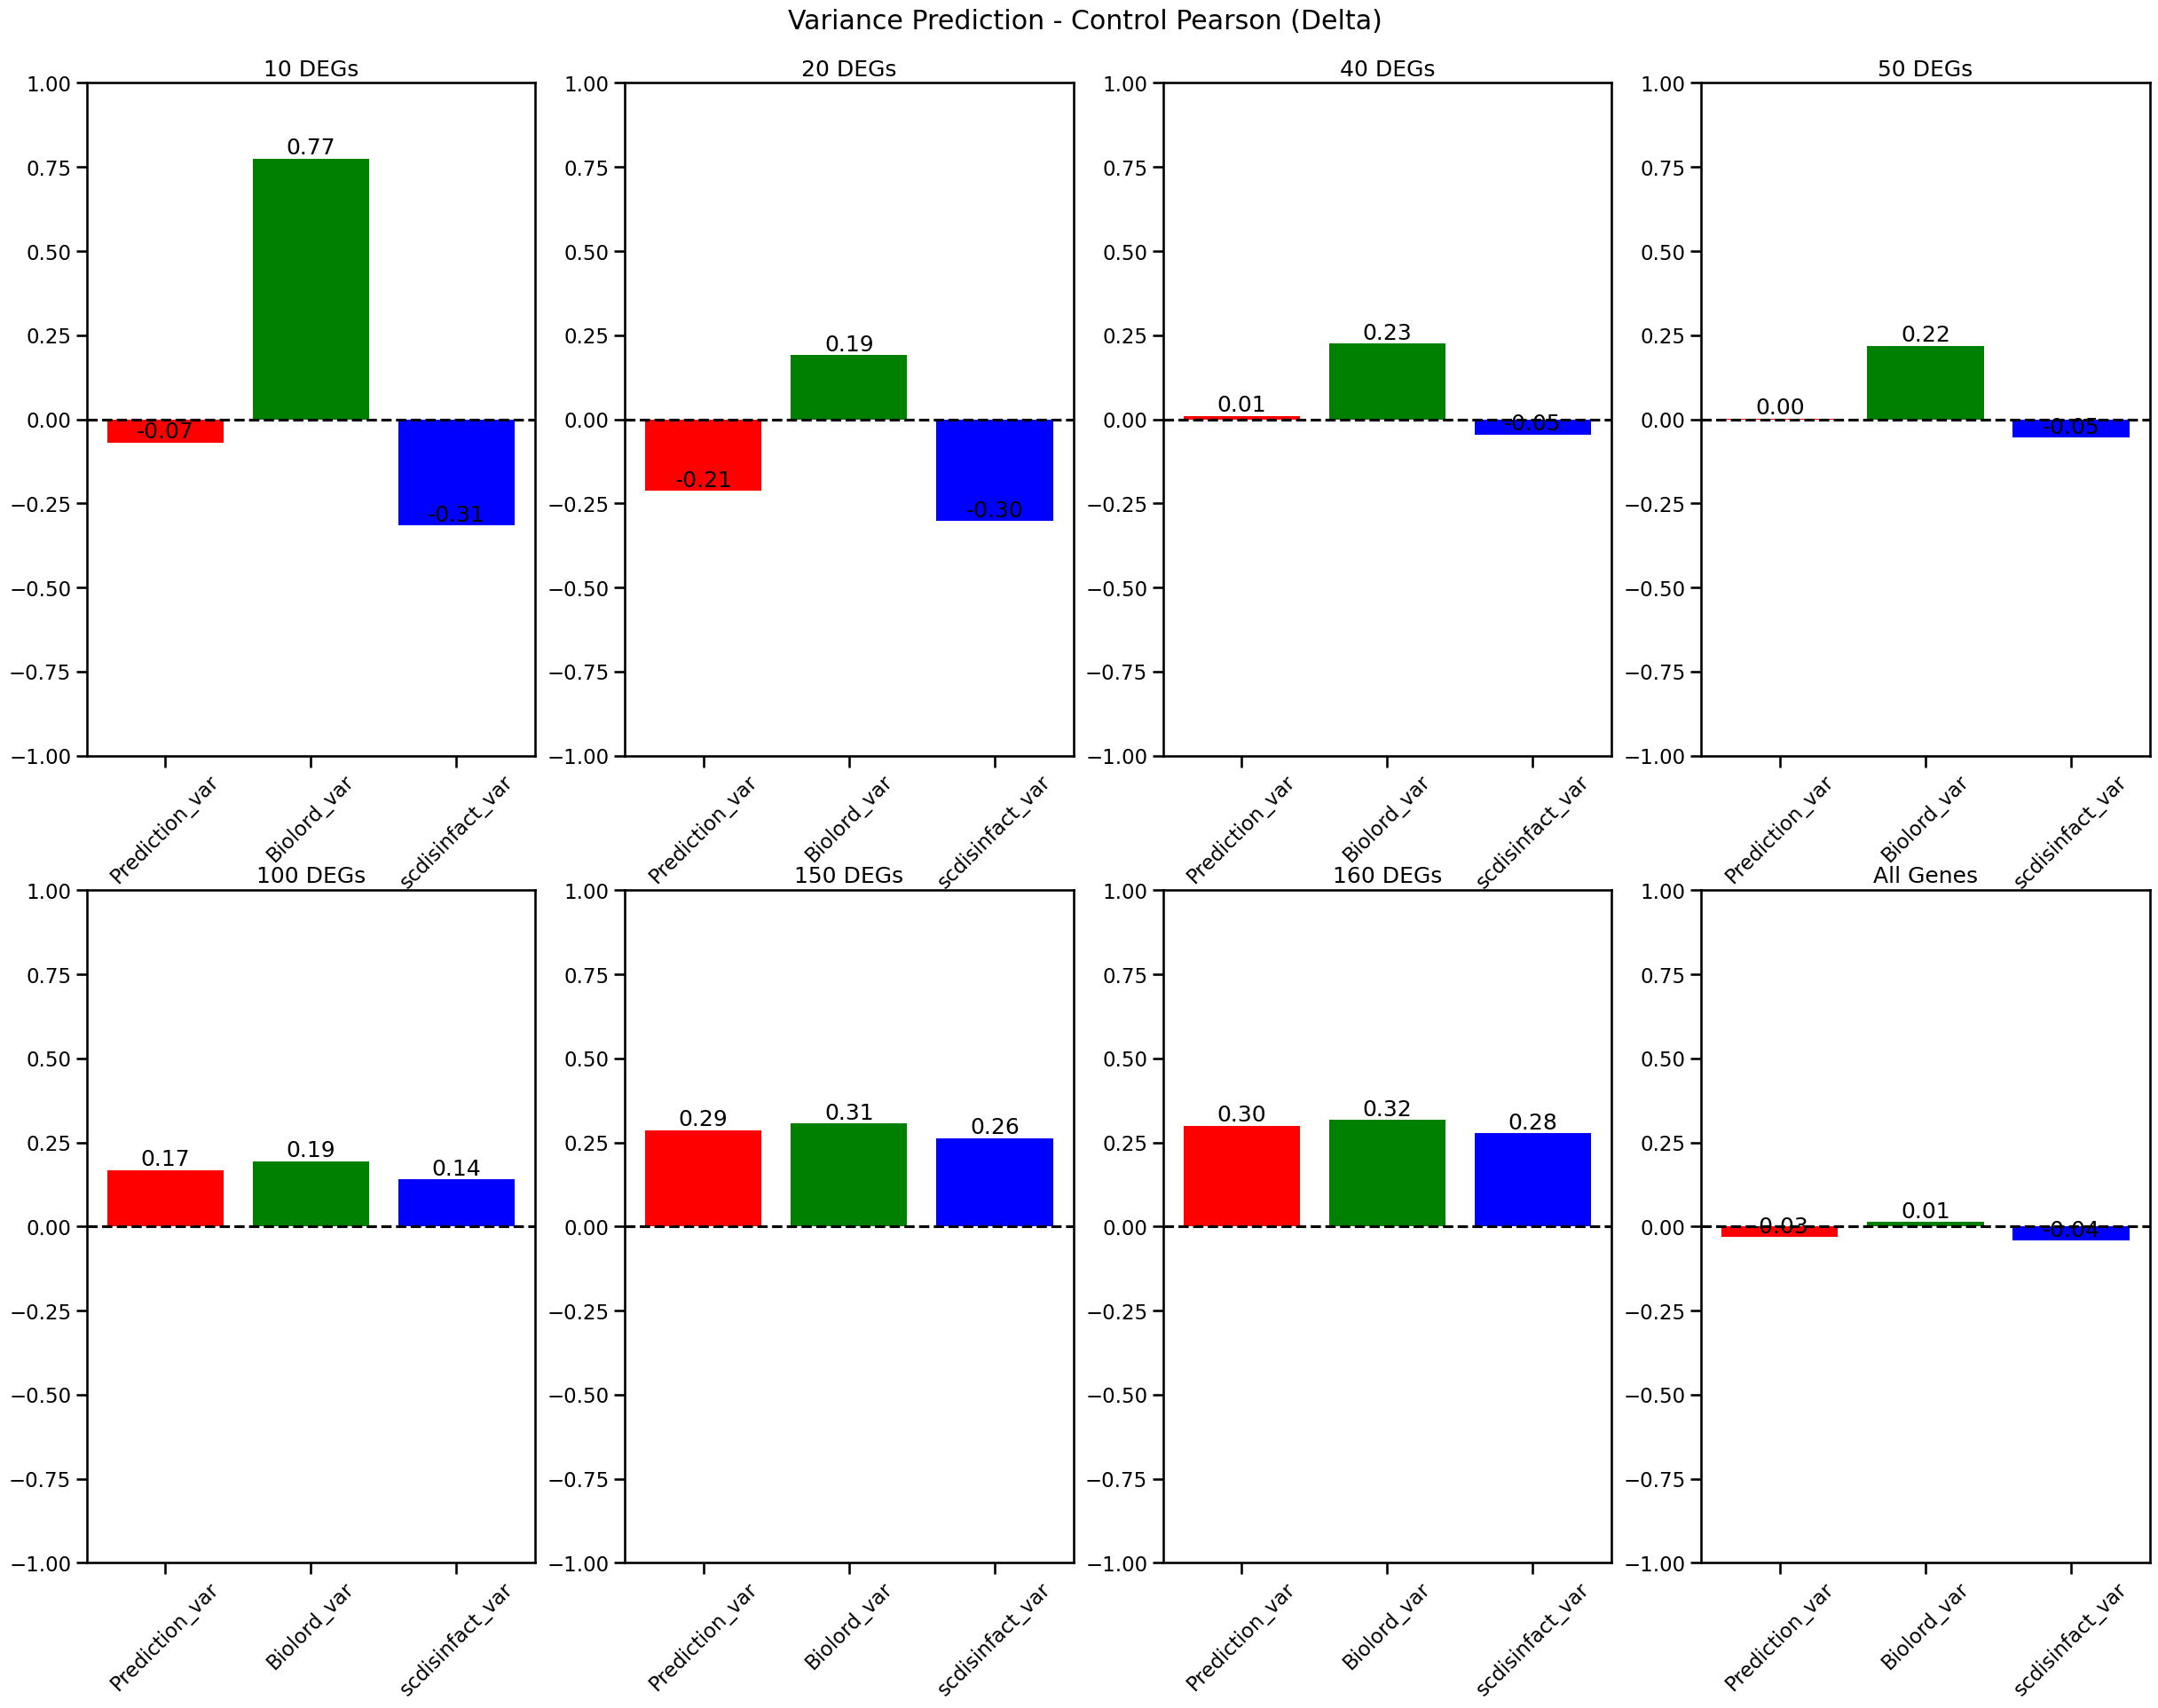

In [78]:
n_rows = r2_results_subtract.shape[0]
df = r2_results_subtract
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][3:]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[3:], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Variance Prediction - Control Pearson (Delta)', y = 1.57)
plt.subplots_adjust(top=1.5)

plt.show()  # Displaying the plot

         Falling back to preprocessing with `sc.pp.pca` and default params.


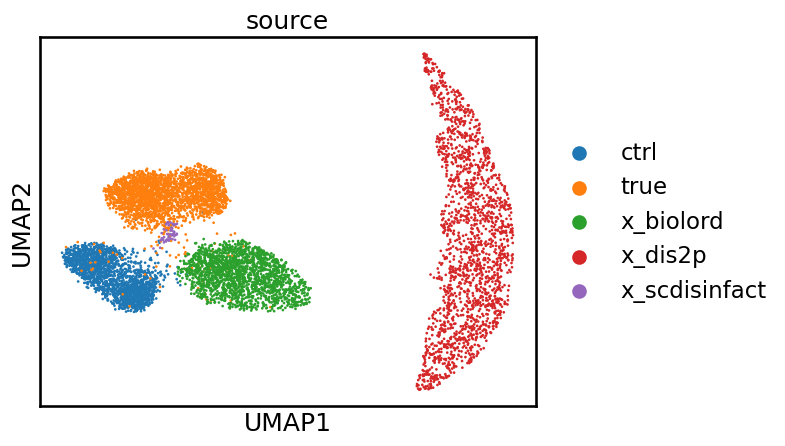

In [36]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_dis2p']*x_pred.shape[0] + ['x_biolord']*x_biolord.shape[0] + ['x_scdisinfact']*x_scdisinfact.shape[0]
from anndata import AnnData
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]).numpy(),
                        obs={'source': obs})
sc.pp.neighbors(results_adata)
sc.tl.umap(results_adata)
sc.pl.umap(results_adata, color='source')

In [37]:
# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    # adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

---UMAP for dis2p_cE_Z_0---


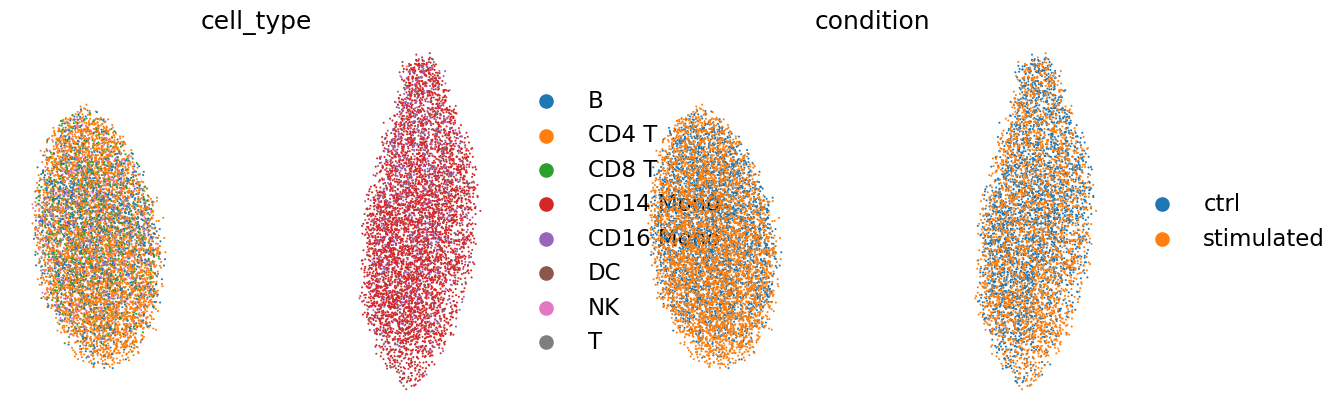

---UMAP for dis2p_cE_Z_1---
cell_type


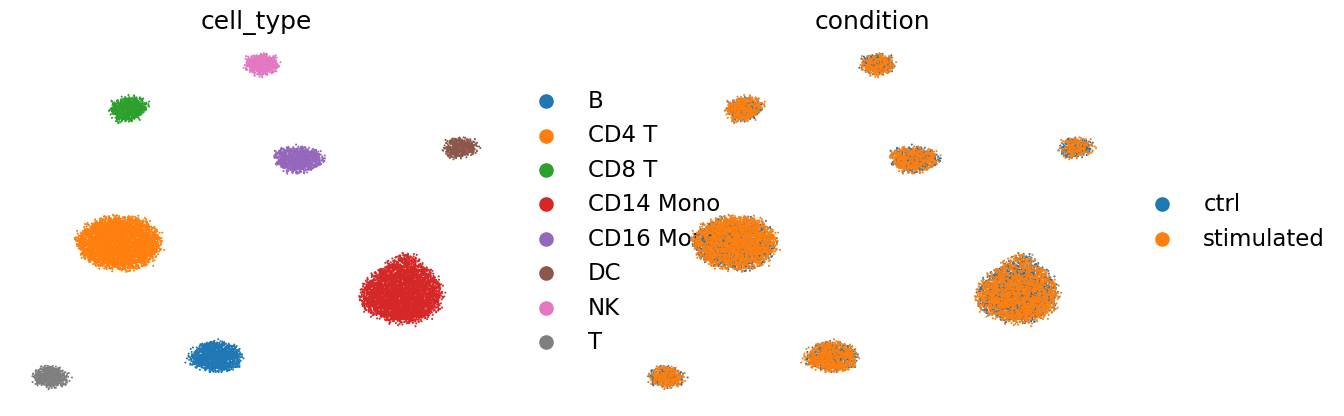

---UMAP for dis2p_cE_Z_2---
condition


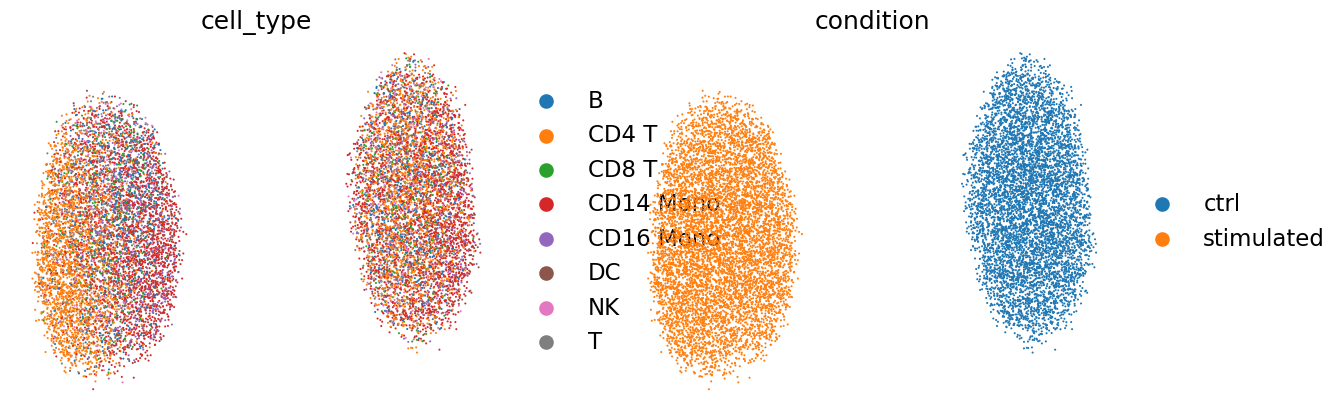

In [38]:
import warnings
warnings.filterwarnings("ignore")
random.seed(0)

# cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']

nrow = len(cats) + 1
ncol = len(cats)

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # legend_loc=None,
        # ax=axs[i][:]
    ) 

In [42]:
for i, cat in enumerate(cats):
    nullify = [c for c in cats if c != cat]
    latent_unknown_attributes_adata, latent_adata = biolord_model.get_latent_representation_adata(
        adata=adata_biolord,
        nullify_attribute=nullify,
    )
    adata.obsm[f'Biolord_Z_{i+1}'] = latent_adata.X.copy()

adata.obsm[f'Biolord_Z_0'] = latent_unknown_attributes_adata.X.copy()

---UMAP for Biolord_Z_0---


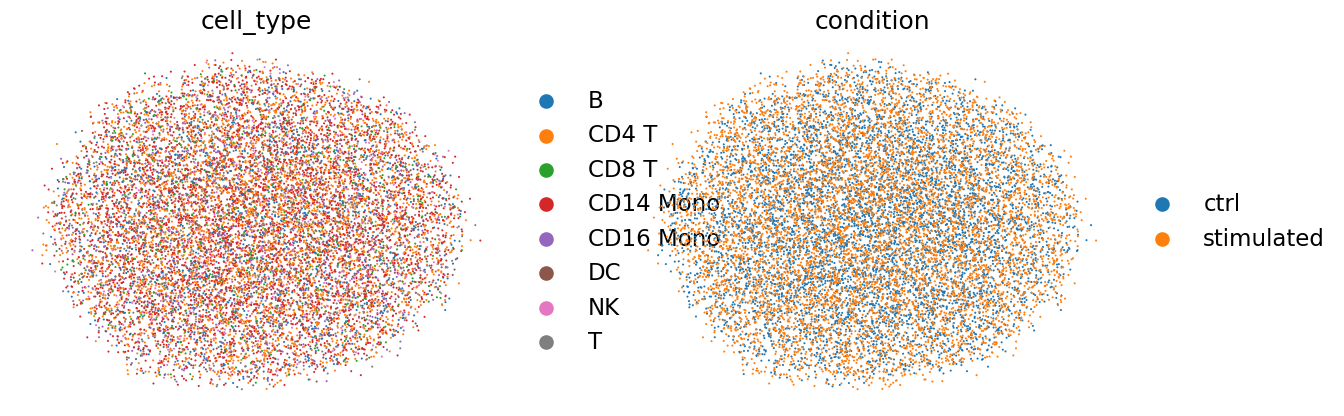

---UMAP for Biolord_Z_1---
cell_type


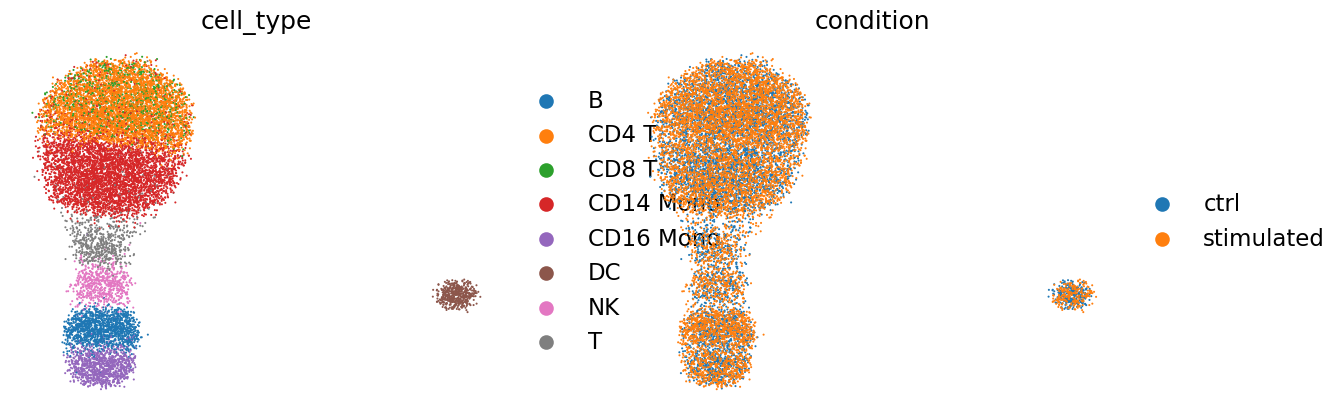

---UMAP for Biolord_Z_2---
condition


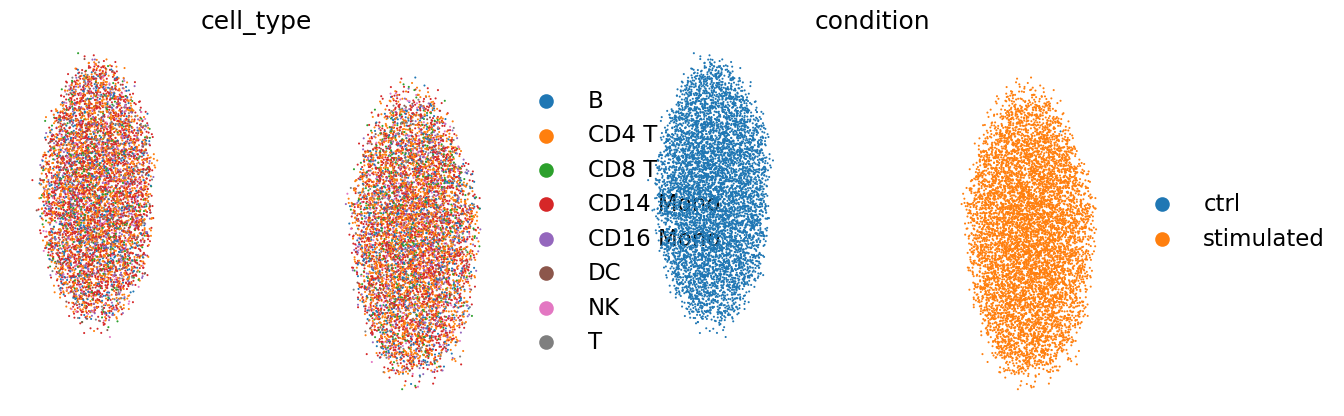

In [43]:
import warnings
warnings.filterwarnings("ignore")
random.seed(0)

nrow = len(cats) + 1
ncol = len(cats)
# sample = random.sample(range(len(adata)), 10000)

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'Biolord_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    # adata_ = adata[sample].copy()
    np.random.seed(0)
    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # legend_loc=None,
        # ax=axs[i][:]
    )

In [27]:
# one forward pass
z_cs = []
z_ds = []
zs = []

# loop through all training count matrices
for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = scdisinfact_model.inference(counts = dataset.counts_norm.to(scdisinfact_model.device), batch_ids = dataset.batch_id[:,None].to(scdisinfact_model.device), print_stat = False)
        # pass through the decoder
        dict_gen = scdisinfact_model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(scdisinfact_model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        mu = dict_gen["mu"]    
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())

# shared-bio factor, concatenate across all training matrices
z_cs = np.concatenate(z_cs, axis = 0)
adata.obsm[f'scDisInfact_Z_0'] = z_cs.copy()

# unshared-bio factors for conditions 1 and 2
for i, cat in enumerate(cats):
    z_ds_cond = np.concatenate([x[i] for x in z_ds], axis = 0)
    adata.obsm[f'scDisInfact_Z_{i+1}'] = z_ds_cond.copy()

---UMAP for scDisInfact_Z_0---


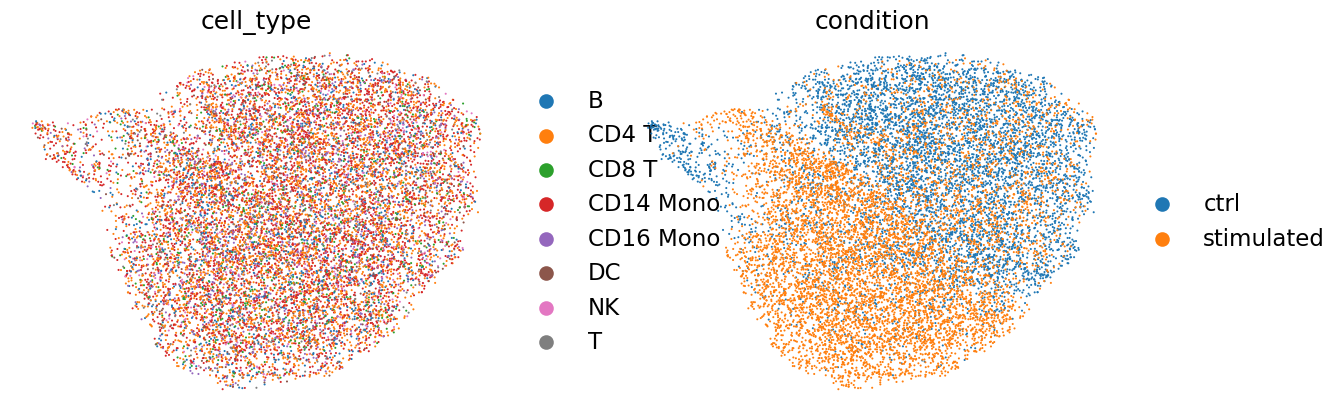

---UMAP for scDisInfact_Z_1---
cell_type


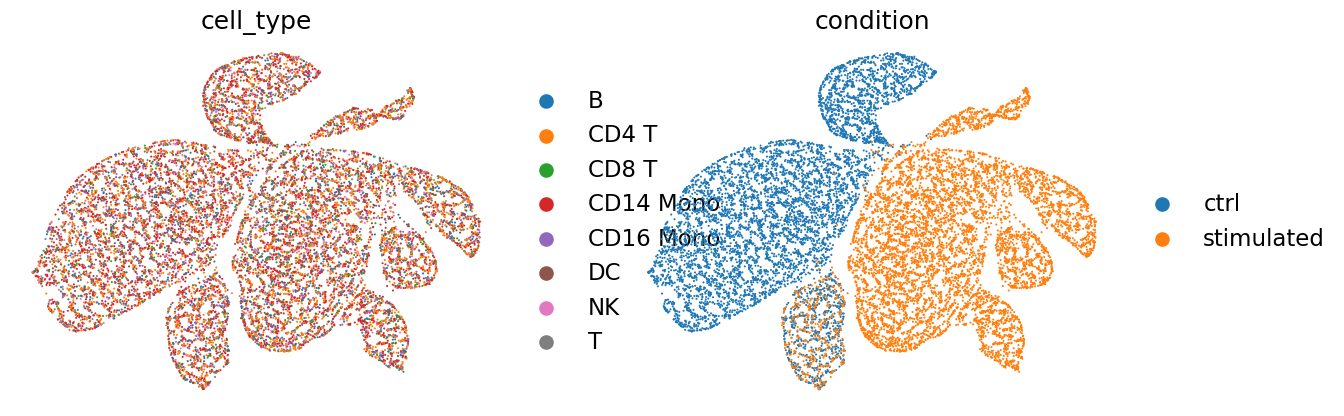

---UMAP for scDisInfact_Z_2---
condition


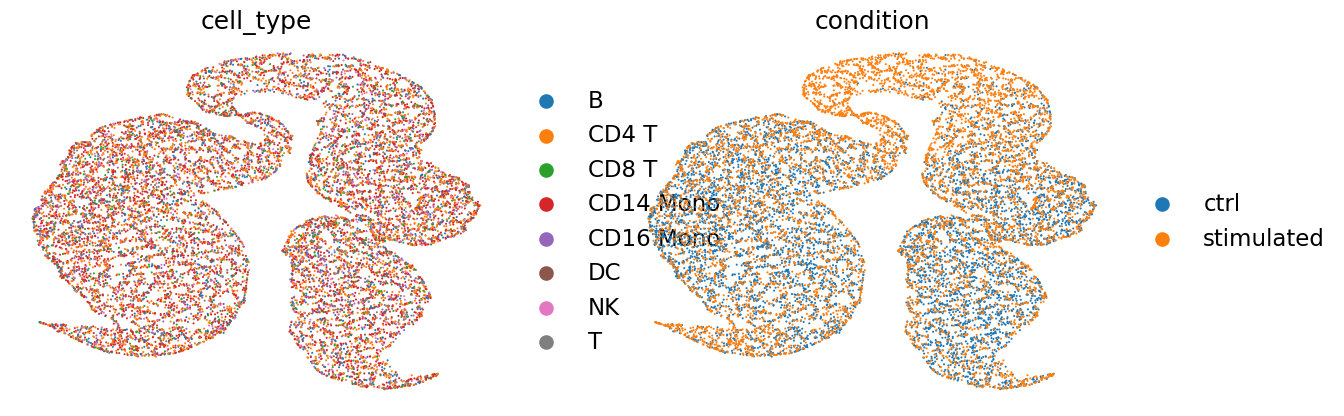

In [28]:
import warnings
warnings.filterwarnings("ignore")
random.seed(0)

# cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']

nrow = len(cats) + 1
ncol = len(cats)
# sample = random.sample(range(len(adata)), 10000)

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'scDisInfact_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    # adata_ = adata[sample].copy()
    np.random.seed(0)
    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # legend_loc=None,
        # ax=axs[i][:]
    )

In [39]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_dis2p']*x_pred.shape[0] + ['x_biolord']*x_biolord.shape[0] + ['x_scdisinfact']*x_scdisinfact.shape[0]
from anndata import AnnData
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]).numpy(),
                        obs={'source': obs},
                        var=adata.var)

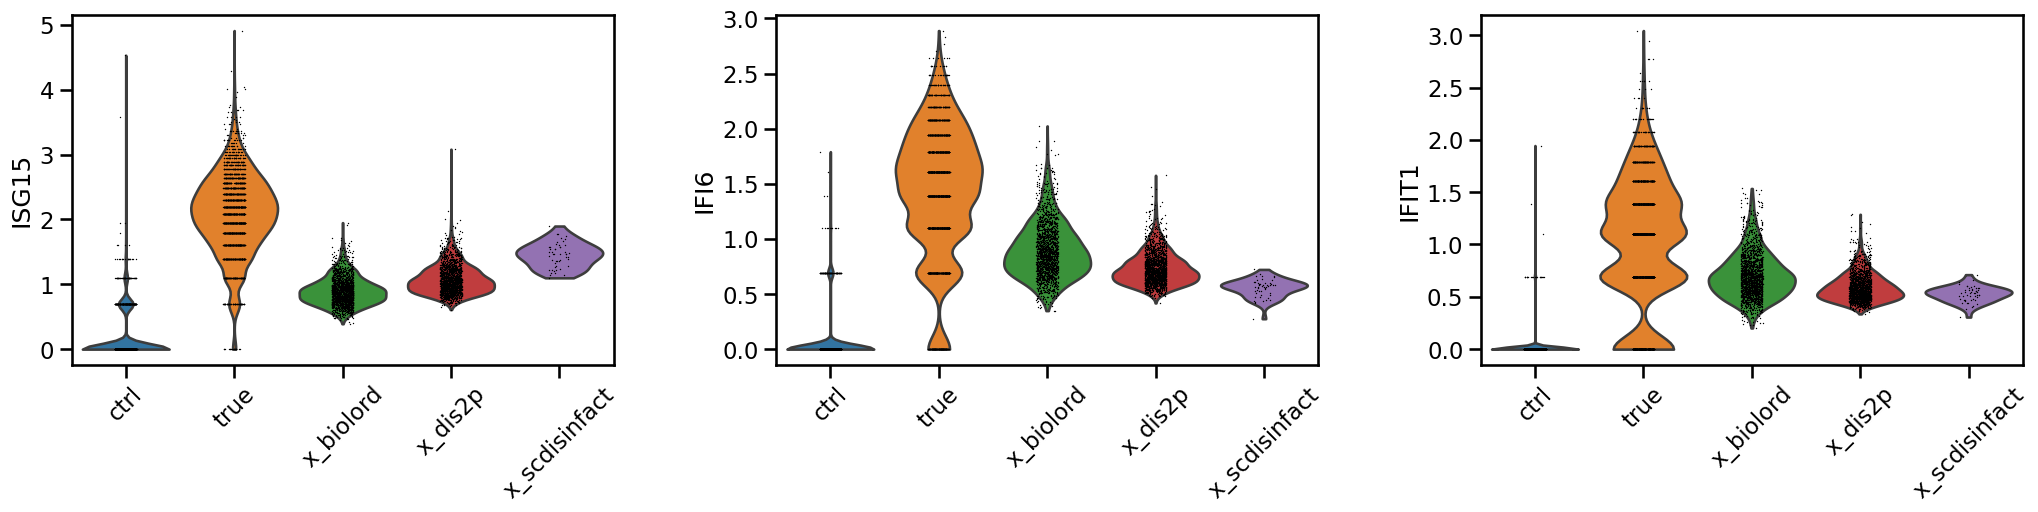

In [40]:
sc.pl.violin(results_adata, ['ISG15', 'IFI6', 'IFIT1'], groupby='source', rotation=45)

In [42]:
gene_list = ["CD3D", "CCL5", "GNLY", "CD79A", "FCGR3A", "S100A9", "HLA-DQA1", 
             "ISG15", "IFI6", "IFIT1", "CXCL10", "CXCL11", "APOBEC3A", "DEFB1", 
             "CCL8", "TARBP1"]

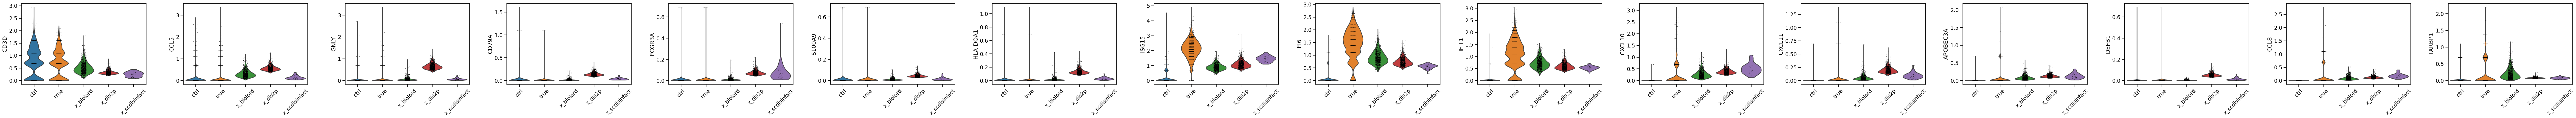

In [43]:
sc.pl.violin(results_adata, gene_list, groupby='source', rotation=45)

In [62]:
adata.obs['ct_condition'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)

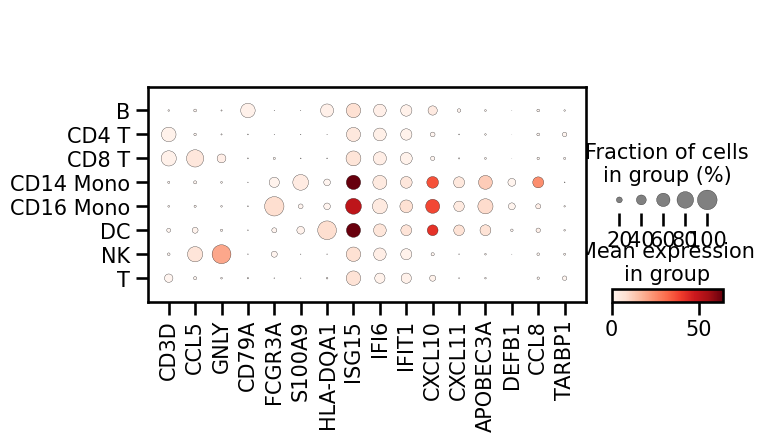

In [66]:
sc.pl.dotplot(adata, var_names=gene_list, groupby="cell_type", show=True)

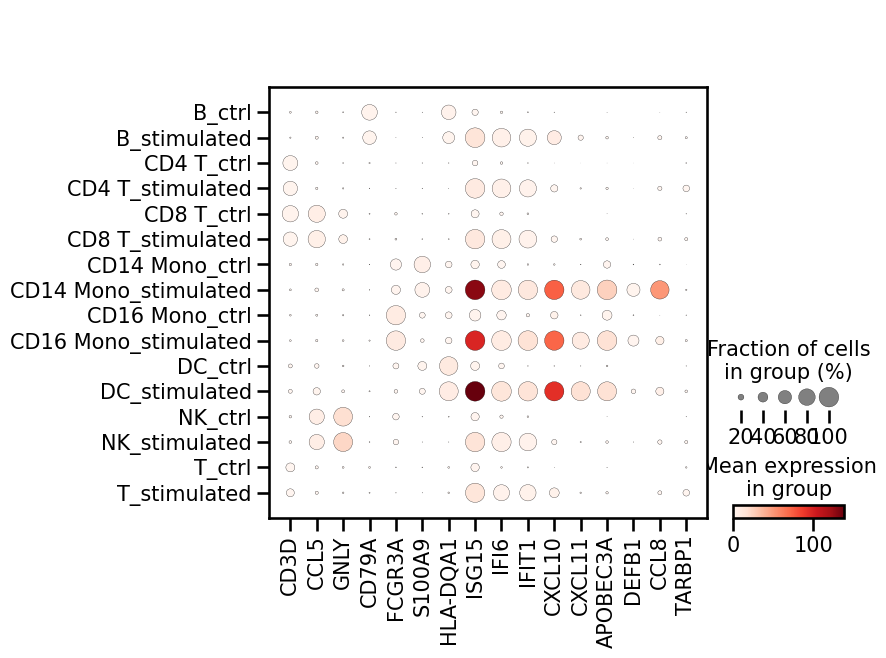

In [63]:
sc.pl.dotplot(adata, var_names=gene_list, groupby="ct_condition", show=True)